В данной домашке предлагается воспроизвести результаты статьи [ArXiv:2006.08545](https://arxiv.org/abs/2006.08545), изучающей поведение NF на Out-Of-Distribution (OOD) данных (т.е. тех данных, которые поток никогда не видел и которые находятся за пределом распределения обучающей выборки)

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext autoreload
%autoreload 2

## (0.3 балла) Обучить Glow на CelebA, добиться нормального качества генерируемых картинок

При невыполнении этого пункта все остальные пункты зануляются

- Скачал селебу
- Стырил код с https://github.com/rosinality/glow-pytorch (Там буквально 2 GLOW.py и train_glow.py)
- Сделал **нормальный лоадер, fix_seed, FID calc и WandB support** в train_glow.py (сюда переносить не стал)
- Выбрал параметры обучения (ниже):

In [3]:
#parser = argparse.ArgumentParser(description="Glow trainer")
#parser.add_argument("--batch", default=64, type=int, help="batch size")
#parser.add_argument("--iter", default=200000, type=int, help="maximum iterations")
#parser.add_argument("--num_epochs", default=30, type=int, help="num epochs")
#parser.add_argument(
#    "--n_flow", default=16, type=int, help="number of flows in each block"
#)
#parser.add_argument("--n_block", default=3, type=int, help="number of blocks")
#parser.add_argument(
#    "--no_lu",
#    action="store_true",
#    help="use plain convolution instead of LU decomposed version",
#)
#parser.add_argument(
#    "--affine", action="store_true", help="use affine coupling instead of additive"
#)
#parser.add_argument("--n_bits", default=5, type=int, help="number of bits")
#parser.add_argument("--lr", default=2e-4, type=float, help="learning rate")
#parser.add_argument("--img_size", default=64, type=int, help="image size")
#parser.add_argument("--temp", default=0.5, type=float, help="temperature of sampling")
#parser.add_argument("--n_sample", default=20, type=int, help="number of samples")

Сломалось на НАН и сделал температуру 0.5 =)

### Обучаем GLOW:

In [ ]:
! python train_glow.py --affine

Namespace(affine=True, batch=64, img_size=64, iter=200000, lr=0.0002, n_bits=5, n_block=3, n_flow=16, n_sample=20, no_lu=False, num_epochs=30, temp=0.5)
wandb: Currently logged in as: kirili4ik (use `wandb login --relogin` to force relogin)
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Tracking run with wandb version 0.10.23
wandb: Syncing run charmed-resonance-31
wandb: ⭐️ View project at https://wandb.ai/kirili4ik/dgm-ht4
wandb: 🚀 View run at https://wandb.ai/kirili4ik/dgm-ht4/runs/3johp9a3
wandb: Run data is saved locally in /workspace/Deep-Generative-Models/homework/4-Glow/wandb/run-20210326_145409-3johp9a3
wandb: Run `wandb offline` to turn off syncing.

/workspace/Deep-Generative-Models/homework/4-Glow/GLOW.py:102: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array t

Училось так 10 эпох, но в копии ноутбука, поэтому сюда не попало.

### Загружаем чекпоинт после 10 эпох и сэмплируем с температурой повыше:

In [163]:
from my_utils import set_seed

set_seed(21)

In [164]:
import torch
from GLOW import Glow

model = Glow(3, 16, 3)
model.load_state_dict(torch.load('model_9'))
#model = model.to('cuda')

<All keys matched successfully>

In [165]:
import wandb

wandb.init(project="dgm-ht4")
wandb.run.name = 'sampling, 10_ep'

wandb: Currently logged in as: kirili4ik (use `wandb login --relogin` to force relogin)


In [169]:
from my_utils import calc_z_shapes
model.eval()

with torch.no_grad():
    for i in range(20):

        z_sample = []
        z_shapes = calc_z_shapes(3, 64, 16, 3)
        for z in z_shapes:
            z_new = torch.randn(20, *z) * 0.3
            z_sample.append(z_new)

        sampled_image = model.reverse(z_sample).detach().cpu()[0]

        wandb.log({"GENERATED temp .33":
                   [wandb.Image(sampled_image.permute(1, 2, 0).numpy(), 
                    caption='generated from noise')]
                   })

In [170]:
from my_utils import calc_z_shapes
model.eval()

with torch.no_grad():
    for i in range(20):

        z_sample = []
        z_shapes = calc_z_shapes(3, 64, 16, 3)
        for z in z_shapes:
            z_new = torch.randn(20, *z) * 0.6
            z_sample.append(z_new)

        sampled_image = model.reverse(z_sample).detach().cpu()[0]

        wandb.log({"GENERATED temp .6":
                   [wandb.Image(sampled_image.permute(1, 2, 0).numpy(), 
                    caption='generated from noise')]
                   })

In [172]:
from my_utils import calc_z_shapes
model.eval()

with torch.no_grad():
    for i in range(30):

        z_sample = []
        z_shapes = calc_z_shapes(3, 64, 16, 3)
        for z in z_shapes:
            z_new = torch.randn(20, *z) * 0.8
            z_sample.append(z_new)

        sampled_image = model.reverse(z_sample).detach().cpu()[0]

        wandb.log({"GENERATED temp .8":
                   [wandb.Image(sampled_image.permute(1, 2, 0).numpy(), 
                    caption='generated from noise')]
                   })

## (0.4 балла) Построить гистограмму лайклихудов для обученного в предыдущем пункте потока для данных CelebA (train), CelebA (test) и SVHN (OOD)
Замечание: из каждого датасета достаточно взять только некоторую долю объектов, достаточную для построения гистограммы 

### Создаем лоадеры для задания:

In [144]:
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader


def get_loaders(BS, image_size):
    celeba_transforms = transforms.Compose([
        transforms.CenterCrop((148, 148)),
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
    ])

    my_dataset = torchvision.datasets.CelebA('./celeba/',
                                           transform=celeba_transforms,
                                           download=False)
    all_size = len(my_dataset)
    
    val_size = 10500
    train_size = all_size - val_size
    train_set, val_set = torch.utils.data.random_split(my_dataset, [train_size, val_size])
    
    train_loader = DataLoader(train_set, batch_size=BS, shuffle=False,
                              num_workers=0, pin_memory=False, drop_last=True)

    val_loader = DataLoader(val_set, batch_size=BS, shuffle=False, drop_last=True)
    return train_loader, val_loader

In [145]:
train_loader, val_loader = get_loaders(BS=1, image_size=64)

In [148]:
def get_loader_SVHN(BS, image_size, split='train'):
    transforms_1 = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
    ])

    my_dataset = torchvision.datasets.SVHN('./SVHN/',
                                           split=split,
                                           transform=transforms_1,
                                           download=True)
    loader = DataLoader(my_dataset, batch_size=BS, shuffle=False,
                        num_workers=0, pin_memory=False, drop_last=True)

    return loader

In [149]:
SVHN_loader = get_loader_SVHN(BS=1, image_size=64, split='train')

Using downloaded and verified file: ./SVHN/train_32x32.mat


### Достаем логлайклихуды:

In [146]:
from tqdm import tqdm
from train_glow import calc_loss

@torch.no_grad()
def get_loglike(model, loader, img_size):
    model.eval()
    dataset_losses = []
    n_bits = 5
    n_bins = 2.0 ** n_bits
    
    for ind, image_attr in tqdm(enumerate(loader)):
        if ind > 1000: break
        image = image_attr[0]
        
        image = image * 255
        image = torch.floor(image / 2 ** (8 - n_bits))
        image = image / n_bins - 0.5
        
        log_p, logdet, _ = model(image + torch.rand_like(image) / n_bins)
        logdet = logdet.mean()
    
        nll, _, _ = calc_loss(log_p, logdet, img_size, n_bins)
        dataset_losses.append(-nll.item())
        
    return dataset_losses

In [147]:
celeba_train_ll = get_loglike(model, train_loader, img_size=64)
celeba_test_ll  = get_loglike(model, val_loader,   img_size=64)

1001it [02:54,  5.72it/s]
1001it [02:54,  5.73it/s]


In [150]:
SVHN_train_ll = get_loglike(model, SVHN_loader, img_size=64)

1001it [02:52,  5.81it/s]


### Визуализация:

In [152]:
import pandas as pd

log_likelihoods = pd.DataFrame({'celeba_train': celeba_train_ll, 
                                'celeba_test' : celeba_test_ll,
                                'SVHN_OOD'    : SVHN_train_ll})

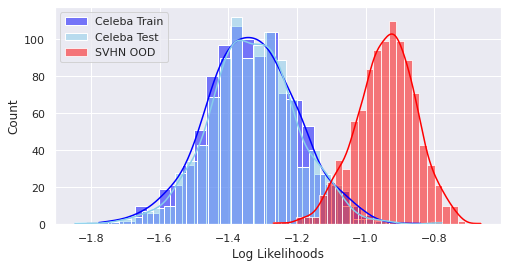

In [153]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
sns.set(style="darkgrid")
figure(figsize=(8, 4))

sns.histplot(data=log_likelihoods, x="celeba_train", color="blue",    label="Celeba Train", kde=True)
sns.histplot(data=log_likelihoods, x="celeba_test",  color="skyblue", label="Celeba Test",  kde=True)
sns.histplot(data=log_likelihoods, x="SVHN_OOD",     color="red",     label="SVHN OOD",     kde=True)

plt.figure
plt.xlabel('Log Likelihoods')
plt.legend()
plt.show()

Как можно заметить, лайклихуд больше на OOD данных.

## (0.3 балла) Сравнить картинки из OOD (SVHN) с наибольшим предсказанным лайклихудом с картинками обучающего датасета (CelebA) с наименьшим лайклихудом. Что можно сказать об этих картинках? Почему лайклихуд первых может быть выше?

In [157]:
celeba_train_best = log_likelihoods['celeba_train'].sort_values(ascending=True).index.values[:10]
celeba_test_best  = log_likelihoods['celeba_test'].sort_values(ascending=True).index.values[:10]
SVHN_best         = log_likelihoods['SVHN_OOD'].sort_values(ascending=False).index.values[:10] 

In [158]:
best = [celeba_train_best, celeba_test_best, SVHN_best]

1002it [00:01, 957.51it/s]
1002it [00:01, 956.27it/s]
1002it [00:00, 3699.58it/s]


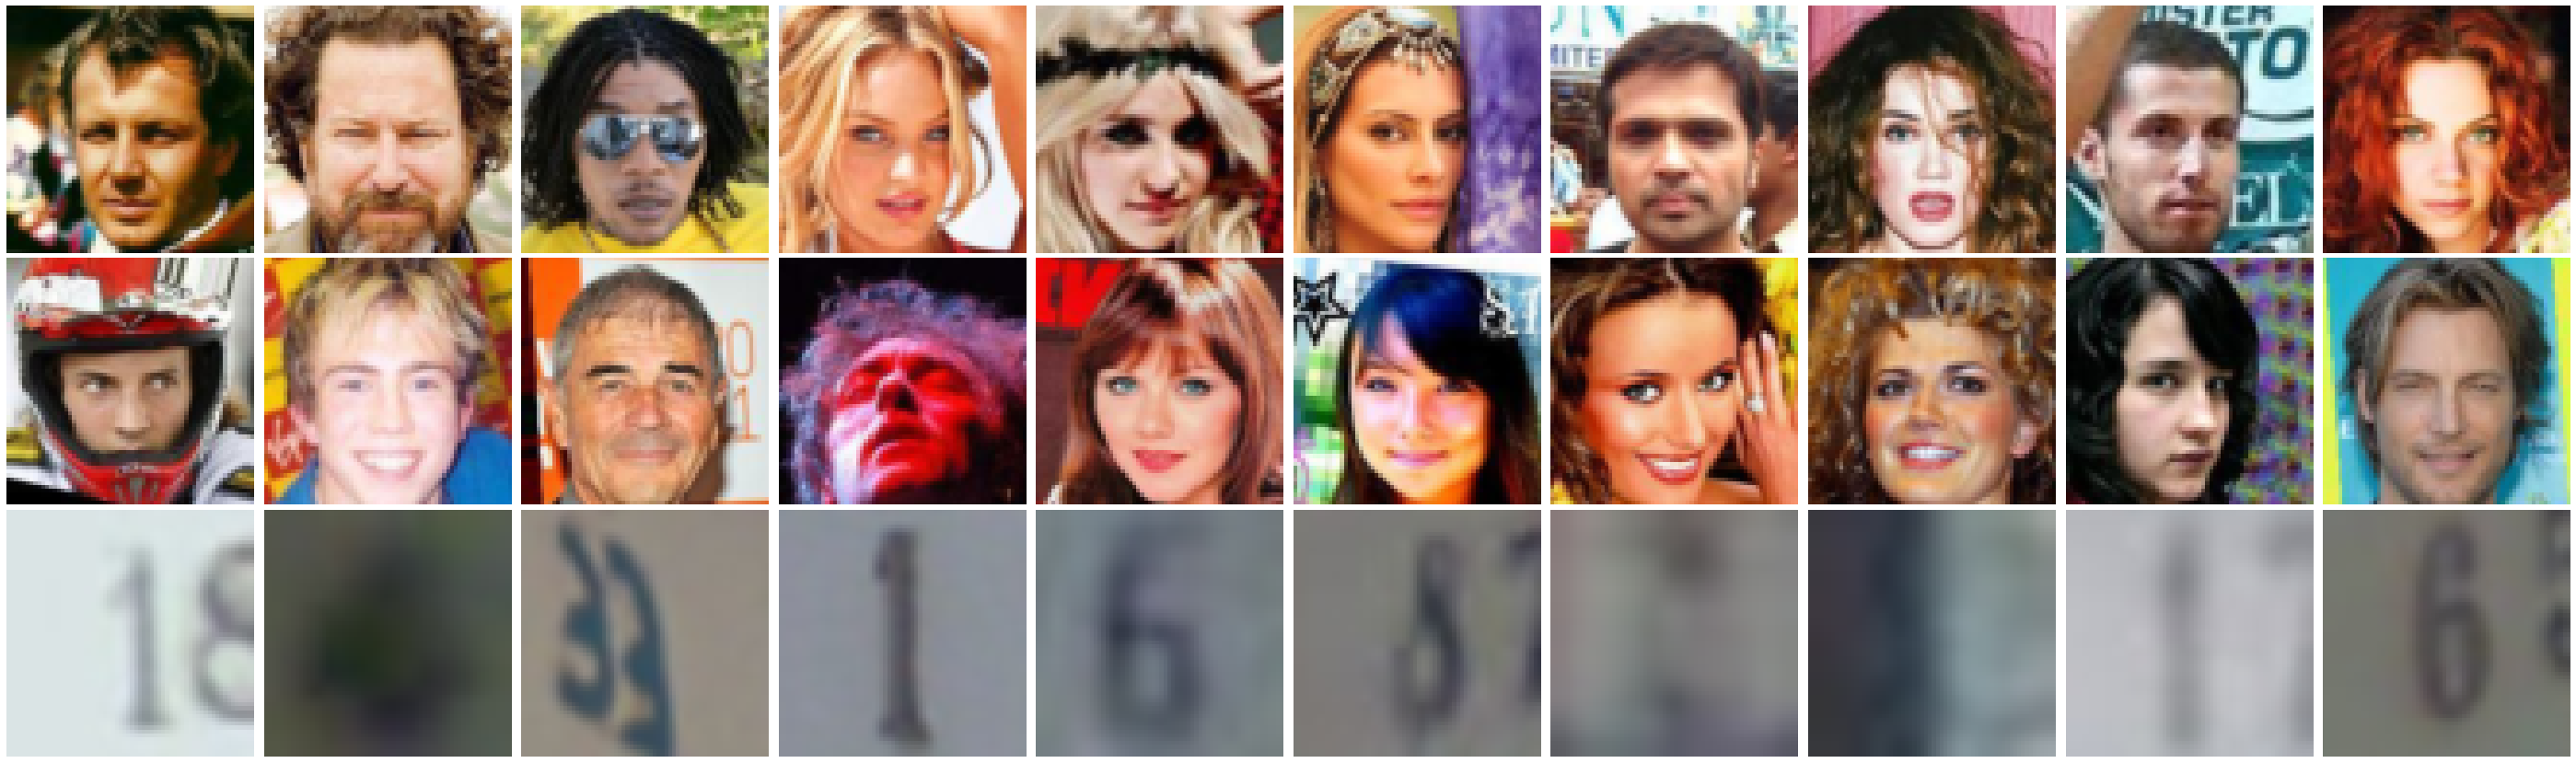

In [159]:
n_bits = 5
n_bins = 2.0 ** n_bits

fig, axs = plt.subplots(3, 10, figsize=(50, 15))
for i, loader in enumerate([train_loader, val_loader, SVHN_loader]):
    pic_num = 0
    for ind, image_attr in tqdm(enumerate(loader)):
        if ind > 1001: break
        if ind in best[i]:
            
            image = image_attr[0]
                    
            axs[i, pic_num].axis("off")
            axs[i, pic_num].imshow(image[0].permute(1, 2, 0).numpy())
            pic_num += 1


plt.subplots_adjust(hspace=0.02, wspace=0.02)    
plt.show()

Можем подтвердить выводы авторов [ArXiv:2006.08545](https://arxiv.org/abs/2006.08545). 

```We argue that flows are biased towards learning graphical properties of the data such as local pixel correlations (e.g. nearby pixels usually have similar colors) rather than semantic properties of the data (e.g. what objects are shown in the image).```

Так у нас и получается:

На 1 пачке катинок лица людей сделаны на очень контрастных фонах, модель присваивает им низкий логлайклихуд. В то же время наибольший логлайклихуд она имеет на размытых фотках чисел. Получается, что несмотря на то, что на фотографиях даже нет лиц, модель присваивает им наибольшие значения логлайклихуда. Вероятно, поток смотрит на локальную корреляцию пикселей больше, чем на семантическую информацию.

Попробуем посмотреть на наибольшие значения логлайклихуда для селебы и наименьшие из OOD:

1002it [00:01, 990.07it/s]
1002it [00:01, 986.56it/s]
1002it [00:00, 3523.69it/s]


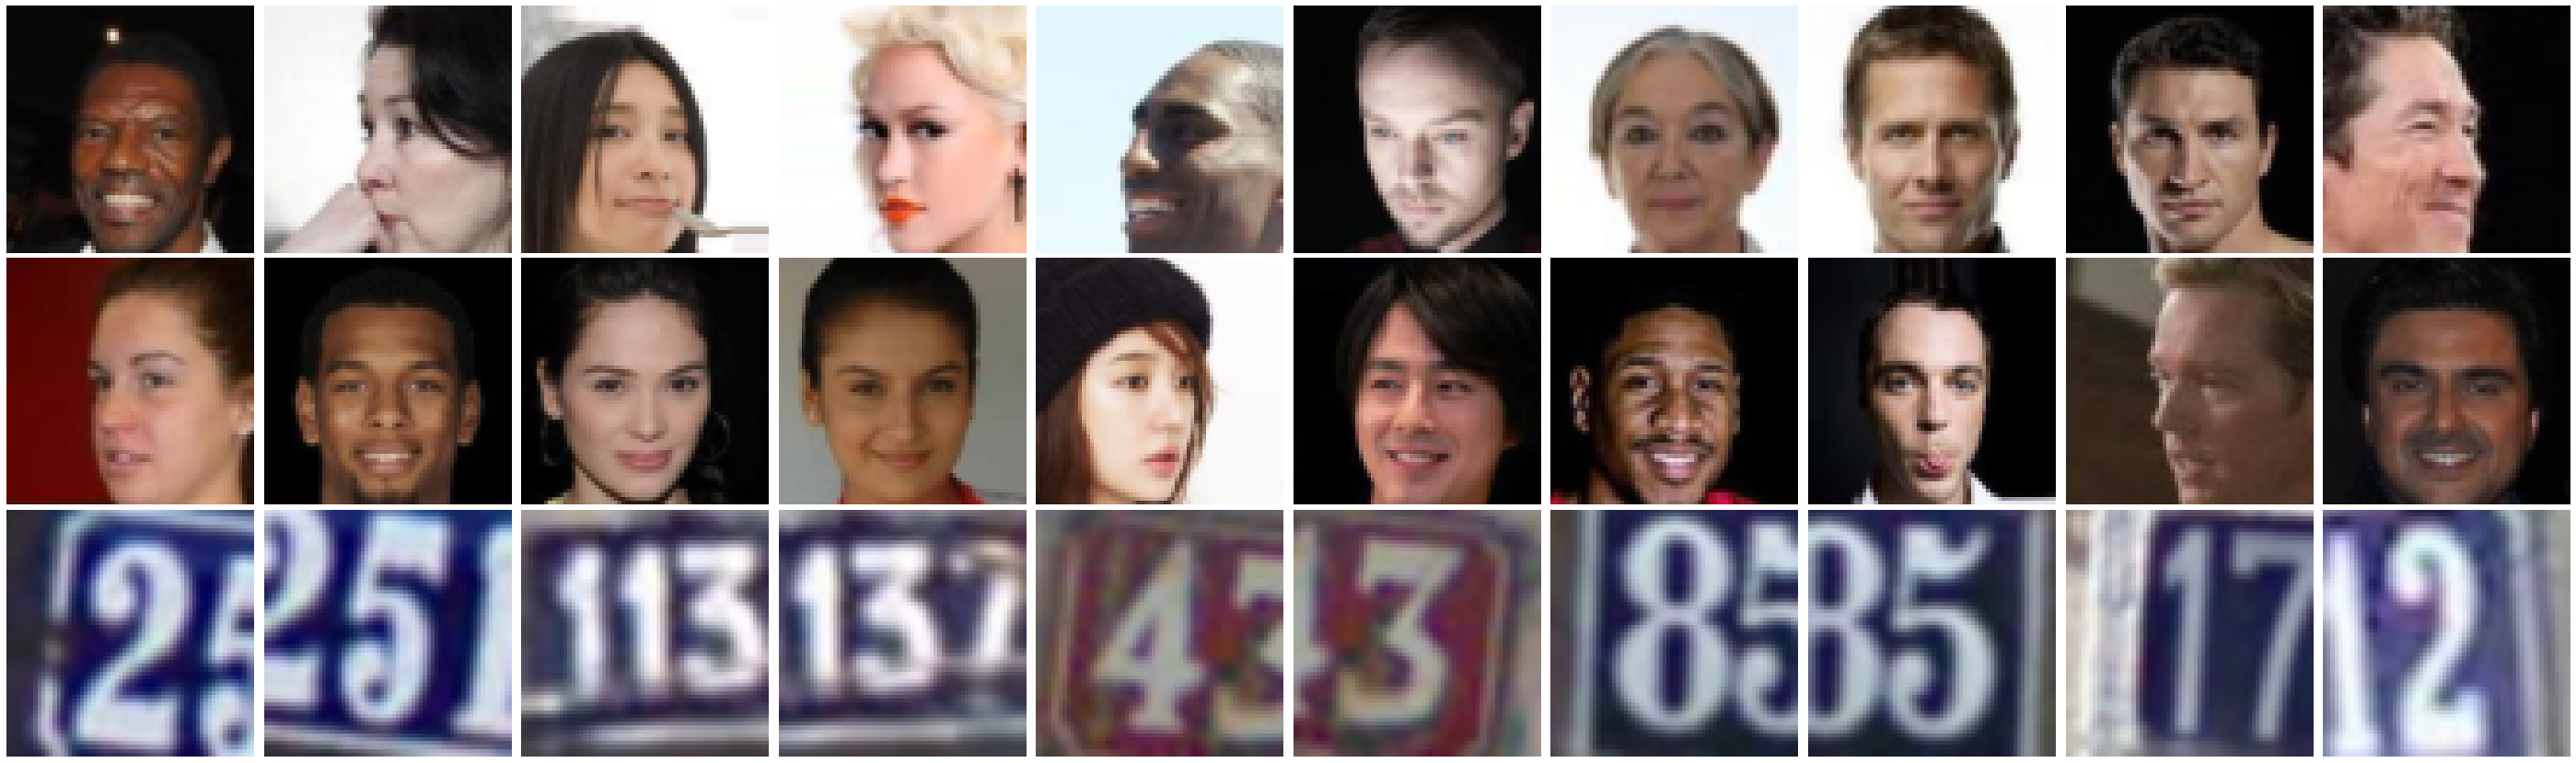

In [139]:
### тут наоброт взял

Как мы и полагали, лица теперь расположены на однотонных фонах. А картинки чисел наоборот наиболее контрастные, на них много локальных областей с резким изнмением цвета (что нельзя сказать здесь про лица). 

#### Примеры нагенеренных картинок и графики:

https://wandb.ai/kirili4ik/dgm-ht4/reports/-4-DGM-GLOW-OOD---Vmlldzo1NjI5OTg